In [1]:
# EEG Data Quality Control Analysis - Complete Pipeline
# Based on the Phase 1-3 Quality Control Checklist
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import argparse
import glob
import cmlreaders as cml
import json
from matplotlib.ticker import FuncFormatter
import warnings
import re
from scipy import signal
from scipy.stats import zscore

# Configure pandas and warnings
pd.set_option('display.max_columns', 1000)
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')
df = cml.get_data_index()
# Change directory location if needed:    
data_dir = "/scratch/new_courier_pilot/"  # pilot data directory
# data_dir = "/scratch/EFRCourier_reports/" # hospital data directory
time_window = 10000  # how long to visualize the data
exp = 'EFRCourierOpenLoop'
df_select=df[df['experiment'] == exp]
allsubject=df_select['subject'].unique()
print(f'{allsubject}')


['FBG490' 'FBG491' 'FR491' 'R1620J' 'R1653J' 'R1693J' 'R1709J' 'R1724J']


In [2]:
subject ='R1620J'
#bed_channel=[101,103,104,105,106,110,111,145,146]
bed_channel=[]
df_select_new = df_select[(df_select['subject'] == subject)]
df_select_new['subject'].unique()
df_select_new['session'].nunique()


2

EEG DATA Report for subject:R1620J
Experiment: EFRCourierOpenLoop
Time window: 10000 ms
Processing session 1 of 2
--------------------------------------------------------------------------------

PHASE 1: DATA LOGIN VERIFICATION
--------------------------------------------------
1.1 EVENT VERIFICATION
------------------------------
START: 1 / 1 - PASS
store mappings: 1 / 1 - PASS
SESS_END: 1 / 1 - PASS
TRIAL_START: 5 / 5 - PASS
TRIAL_END: 5 / 5 - PASS
WORD: 60 / 60 - PASS
STIM: 147 / 89 or 91 - FAIL
pointing begins: 65 / 65 - PASS
pointing finished: 65 / 65 - PASS
REC_START: 5 / 5 - PASS
REC_STOP: 5 / 5 - PASS
CUED_REC_CUE: 60 / 60 - PASS
CUED_REC_STOP: 60 / 60 - PASS

1.2 STIMULUS DELIVERY VALIDATION
------------------------------
8 Hz stimuli events: 64
3 Hz stimuli events: 83
No stimuli events: 607

Stimuli distribution by phase:
Encoding - 3 Hz: 15, 8 Hz: 12, None: 33
Retrieval - 3 Hz: 45, 8 Hz: 30

PHASE 2: FREQUENCY ANALYSIS (3-8 Hz Peak Detection)
-------------------------------

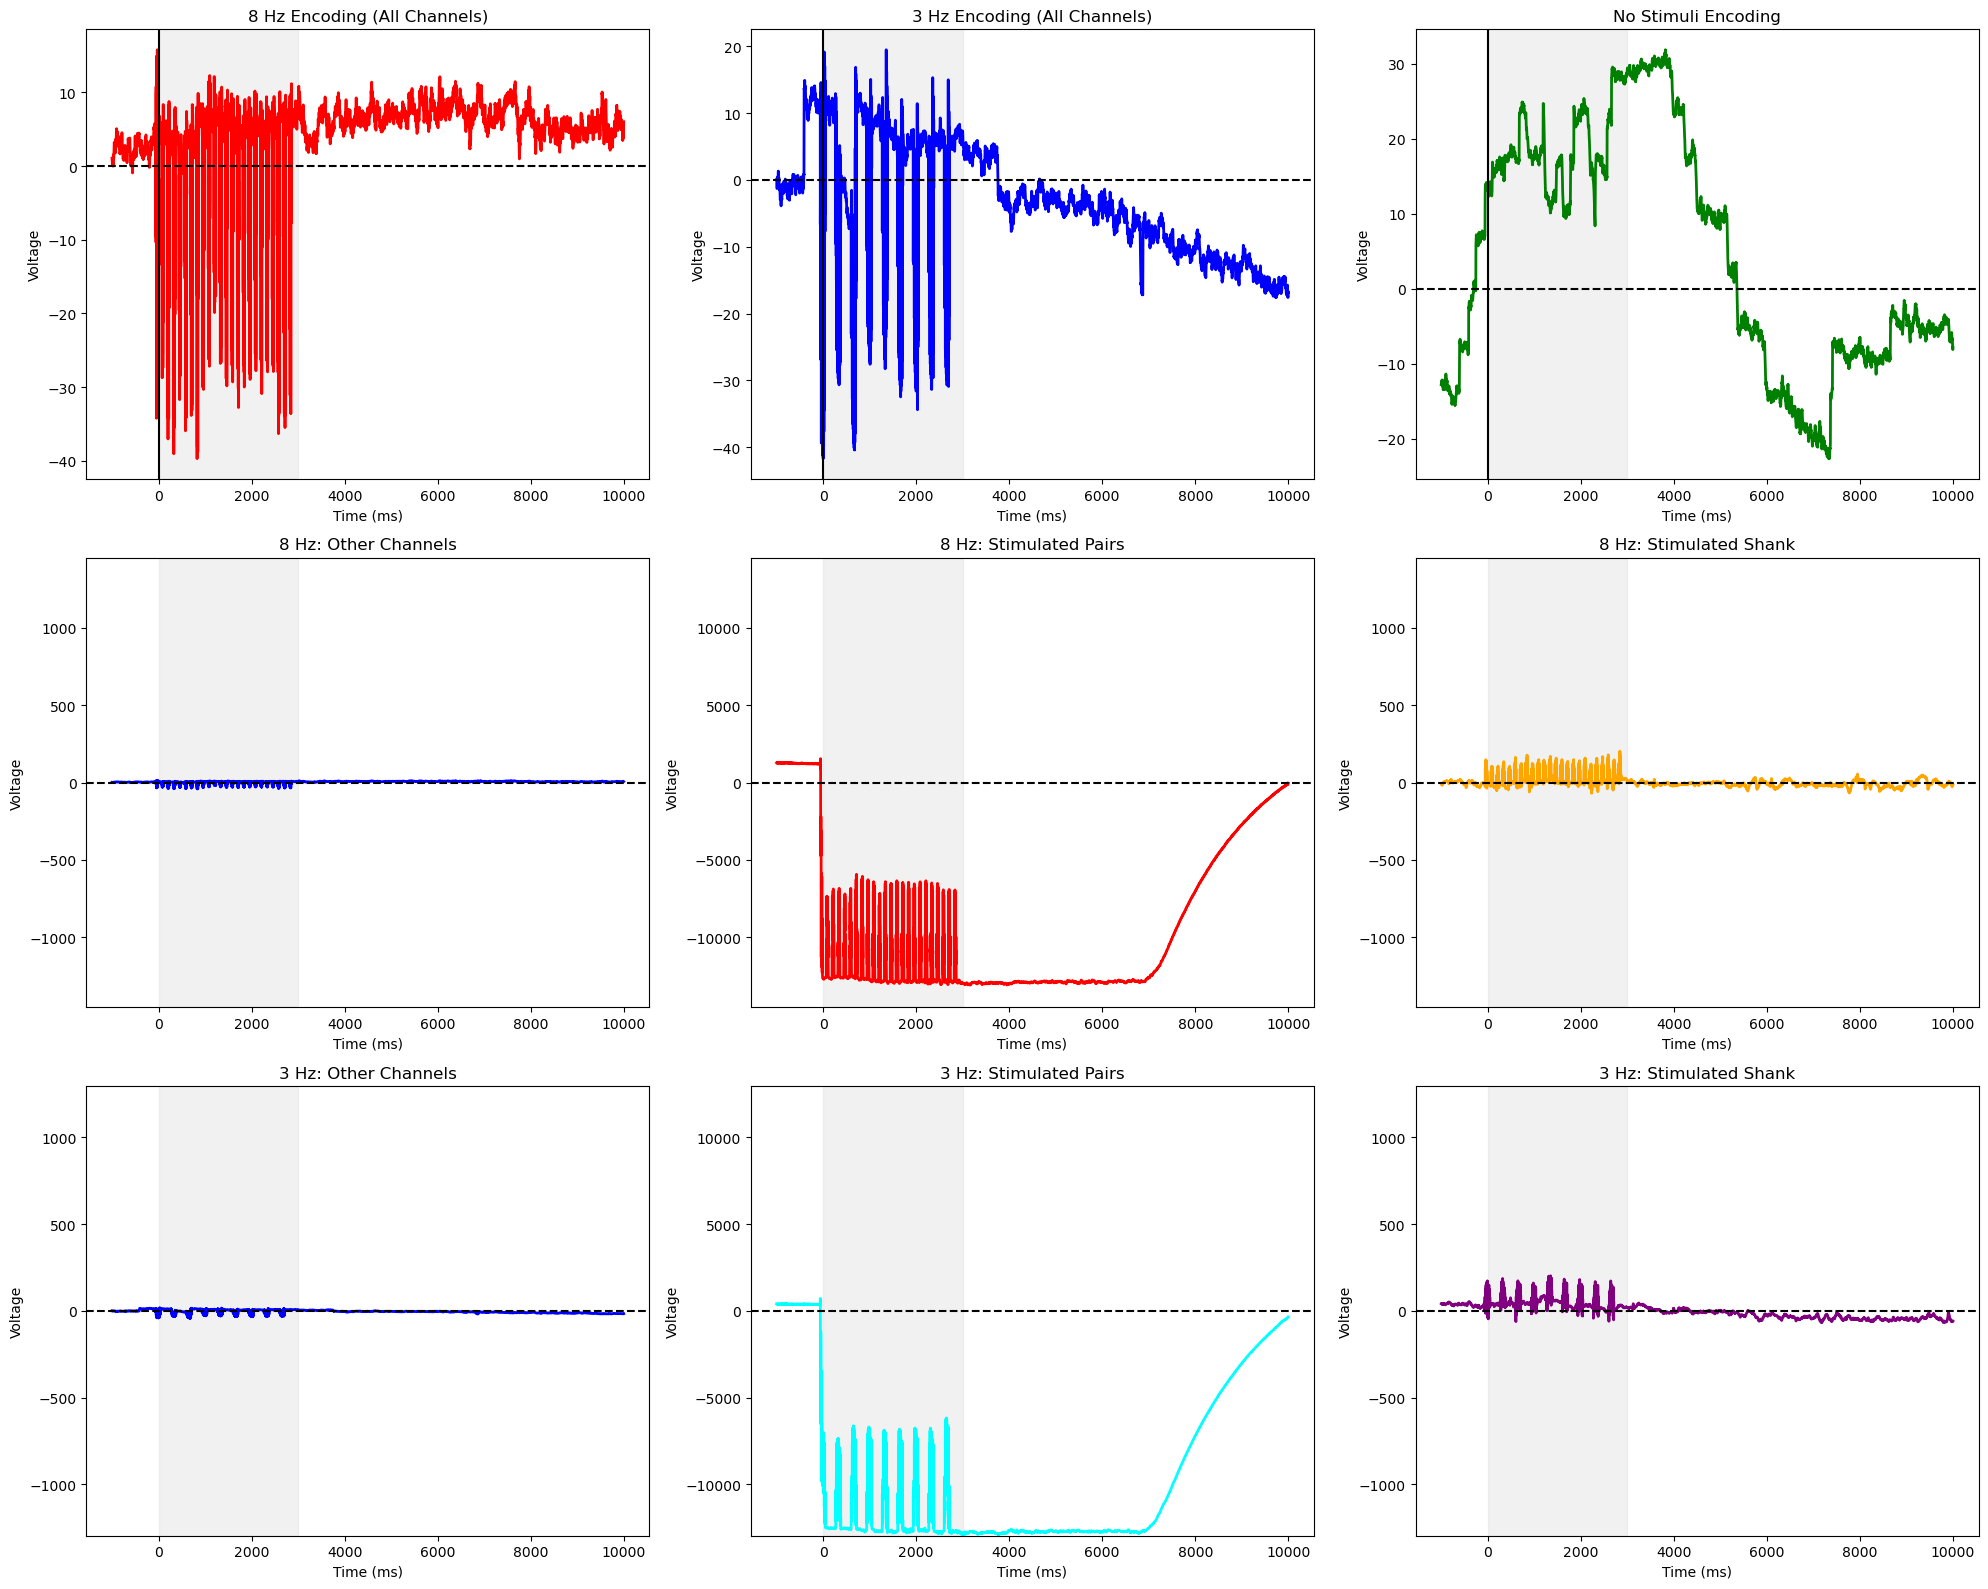

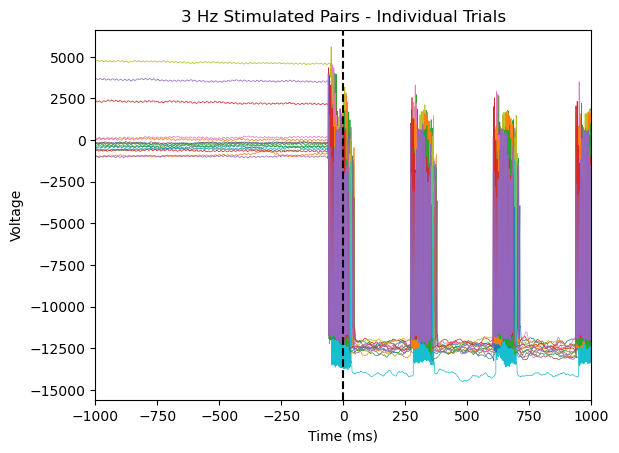

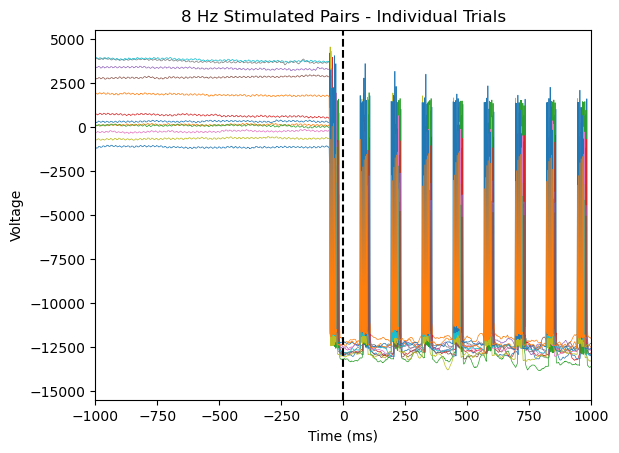


PHASE 3: CHANNEL QUALITY ASSESSMENT
--------------------------------------------------
------------------------------


No handles with labels found to put in legend.


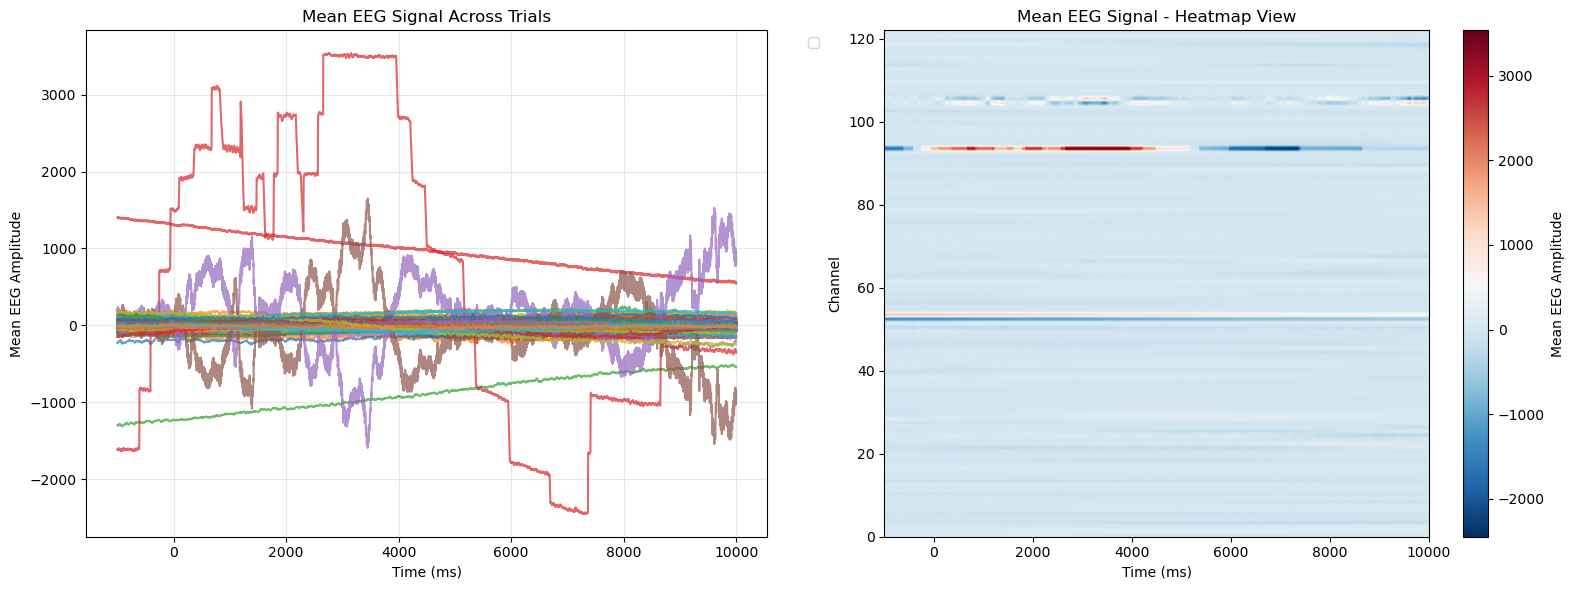

Total channels analyzed: 122
Channels with high variability (|z-score| > 2): 5

Problematic channels:
  Channel 52: RMTP4-RMTP5 (z-score: 2.40)
  Channel 53: RMTP5-RMTP6 (z-score: 2.43)
  Channel 93: RPB11-RPB12 (z-score: 8.59)
  Channel 104: RPLG11-RPLG12 (z-score: 3.65)
  Channel 105: RPLG12-RPLG13 (z-score: 3.61)


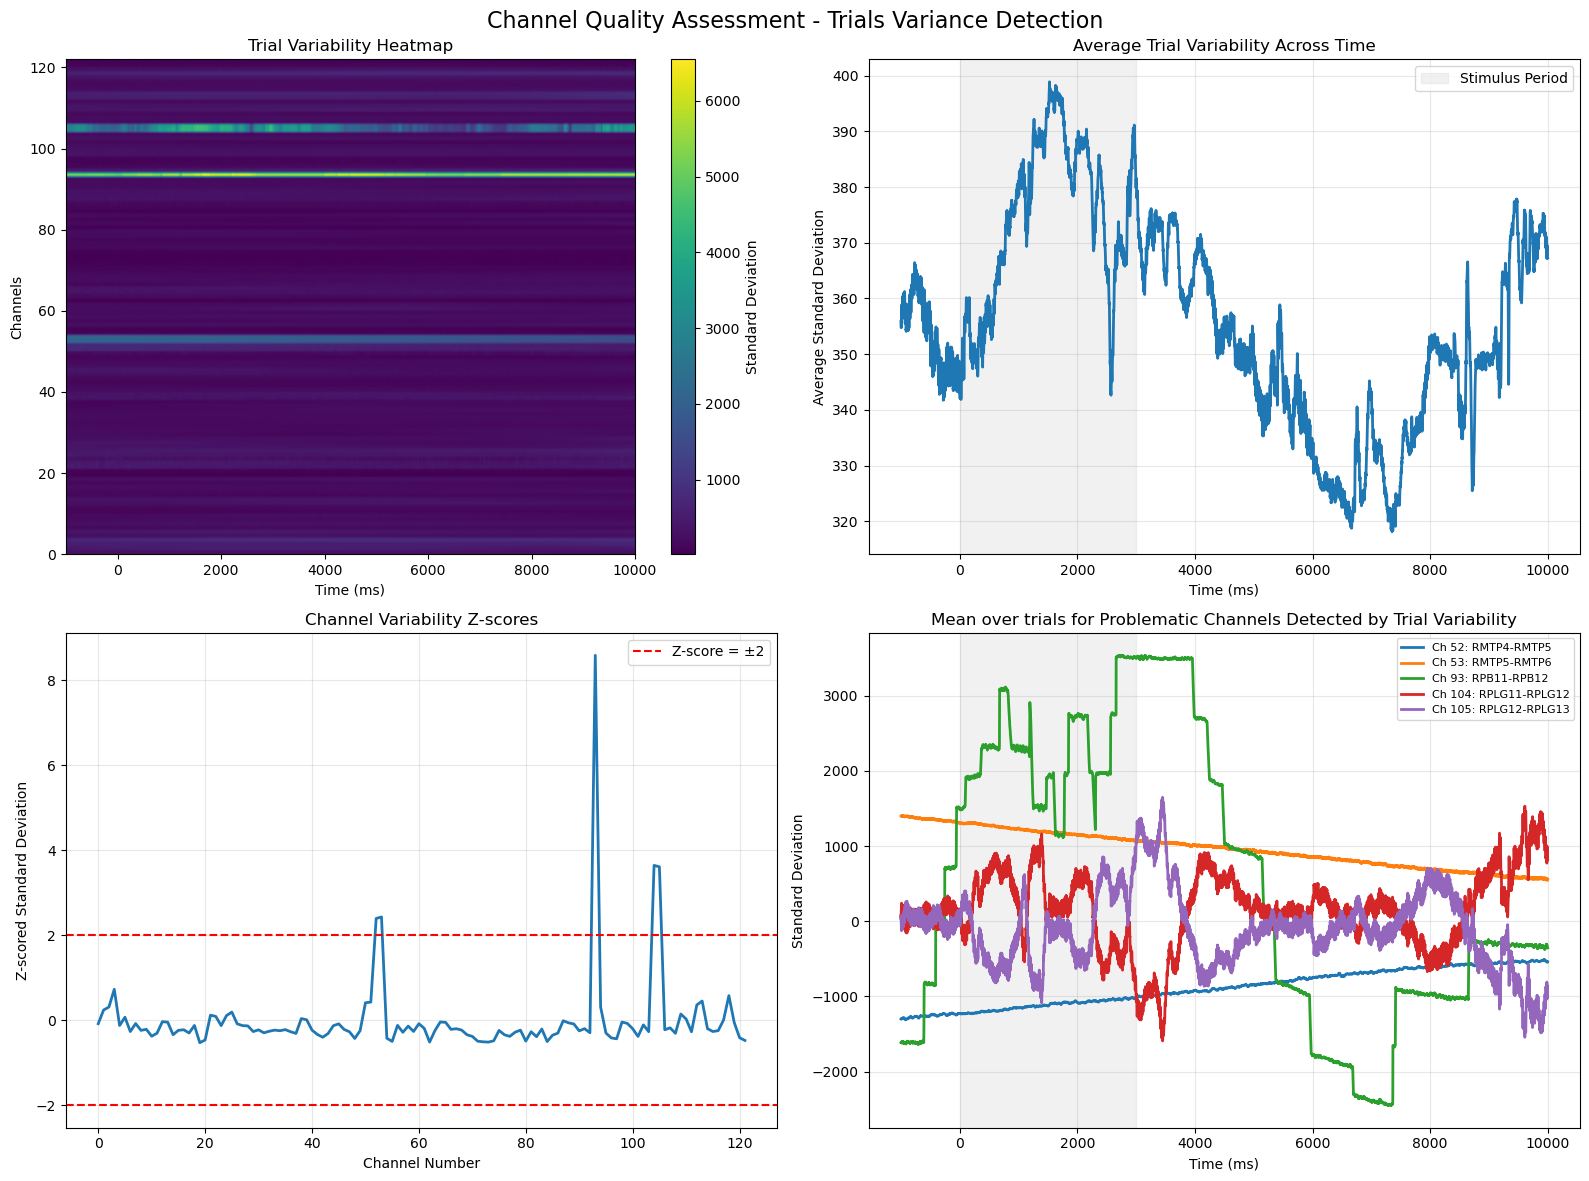

Total channels analyzed: 122
Channels with high timepoint variance (|z-score| > 2): 3

Problematic channels:
  Channel 93: RPB11-RPB12 (z-score: 10.28)
  Channel 104: RPLG11-RPLG12 (z-score: 2.67)
  Channel 105: RPLG12-RPLG13 (z-score: 2.65)


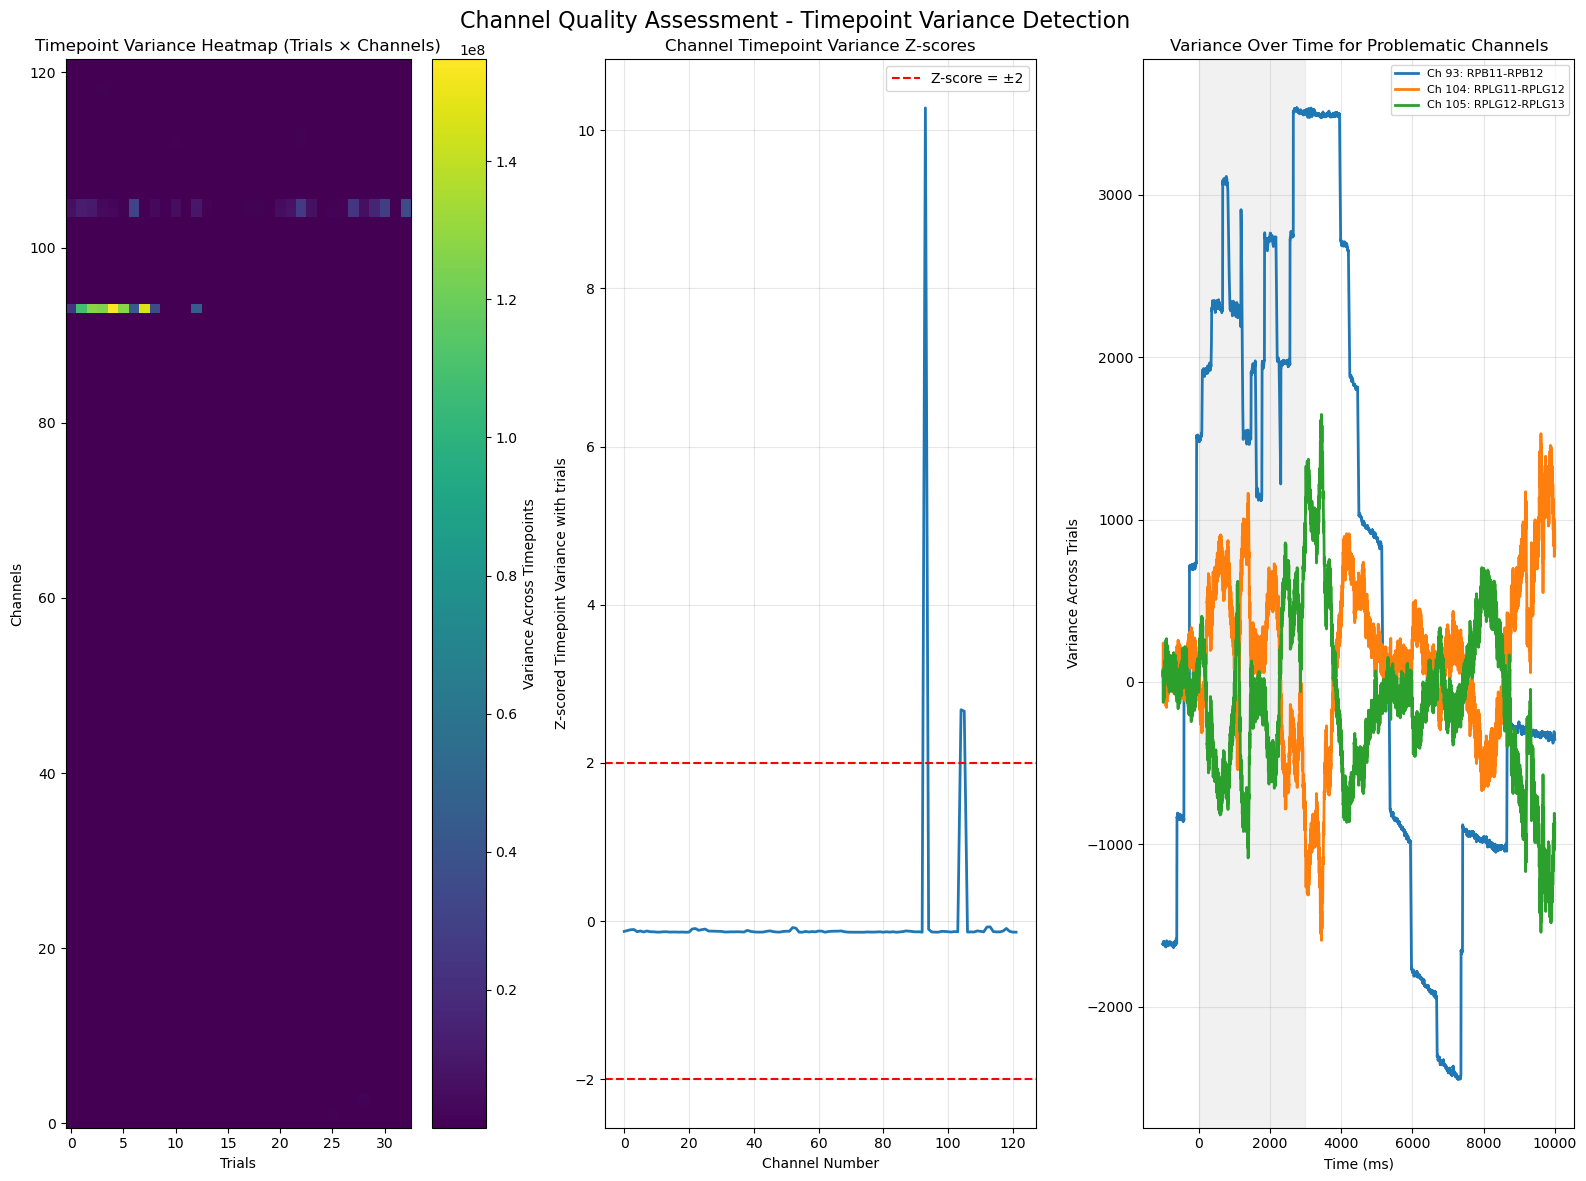


PHASE 4: Behavioral results
--------------------------------------------------
   Burst frequency (Hz)   DD  recall_rate  intrusion  Number of encoding stim  \
0                   3.0  0.0     0.500000        9.0                      5.0   
1                   8.0  1.0     0.416667        6.0                      6.0   
2                   3.0  2.0     0.500000        6.0                      5.0   
3                   8.0  3.0     0.250000        6.0                      6.0   
4                   3.0  4.0     0.083333        1.0                      5.0   

   Number of retrieval stim (EFR)  
0                            15.0  
1                            15.0  
2                            15.0  
3                            15.0  
4                            15.0  
EEG DATA Report for subject:R1620J
Experiment: EFRCourierOpenLoop
Time window: 10000 ms
Processing session 2 of 2
--------------------------------------------------------------------------------

PHASE 1: DATA LOGIN V

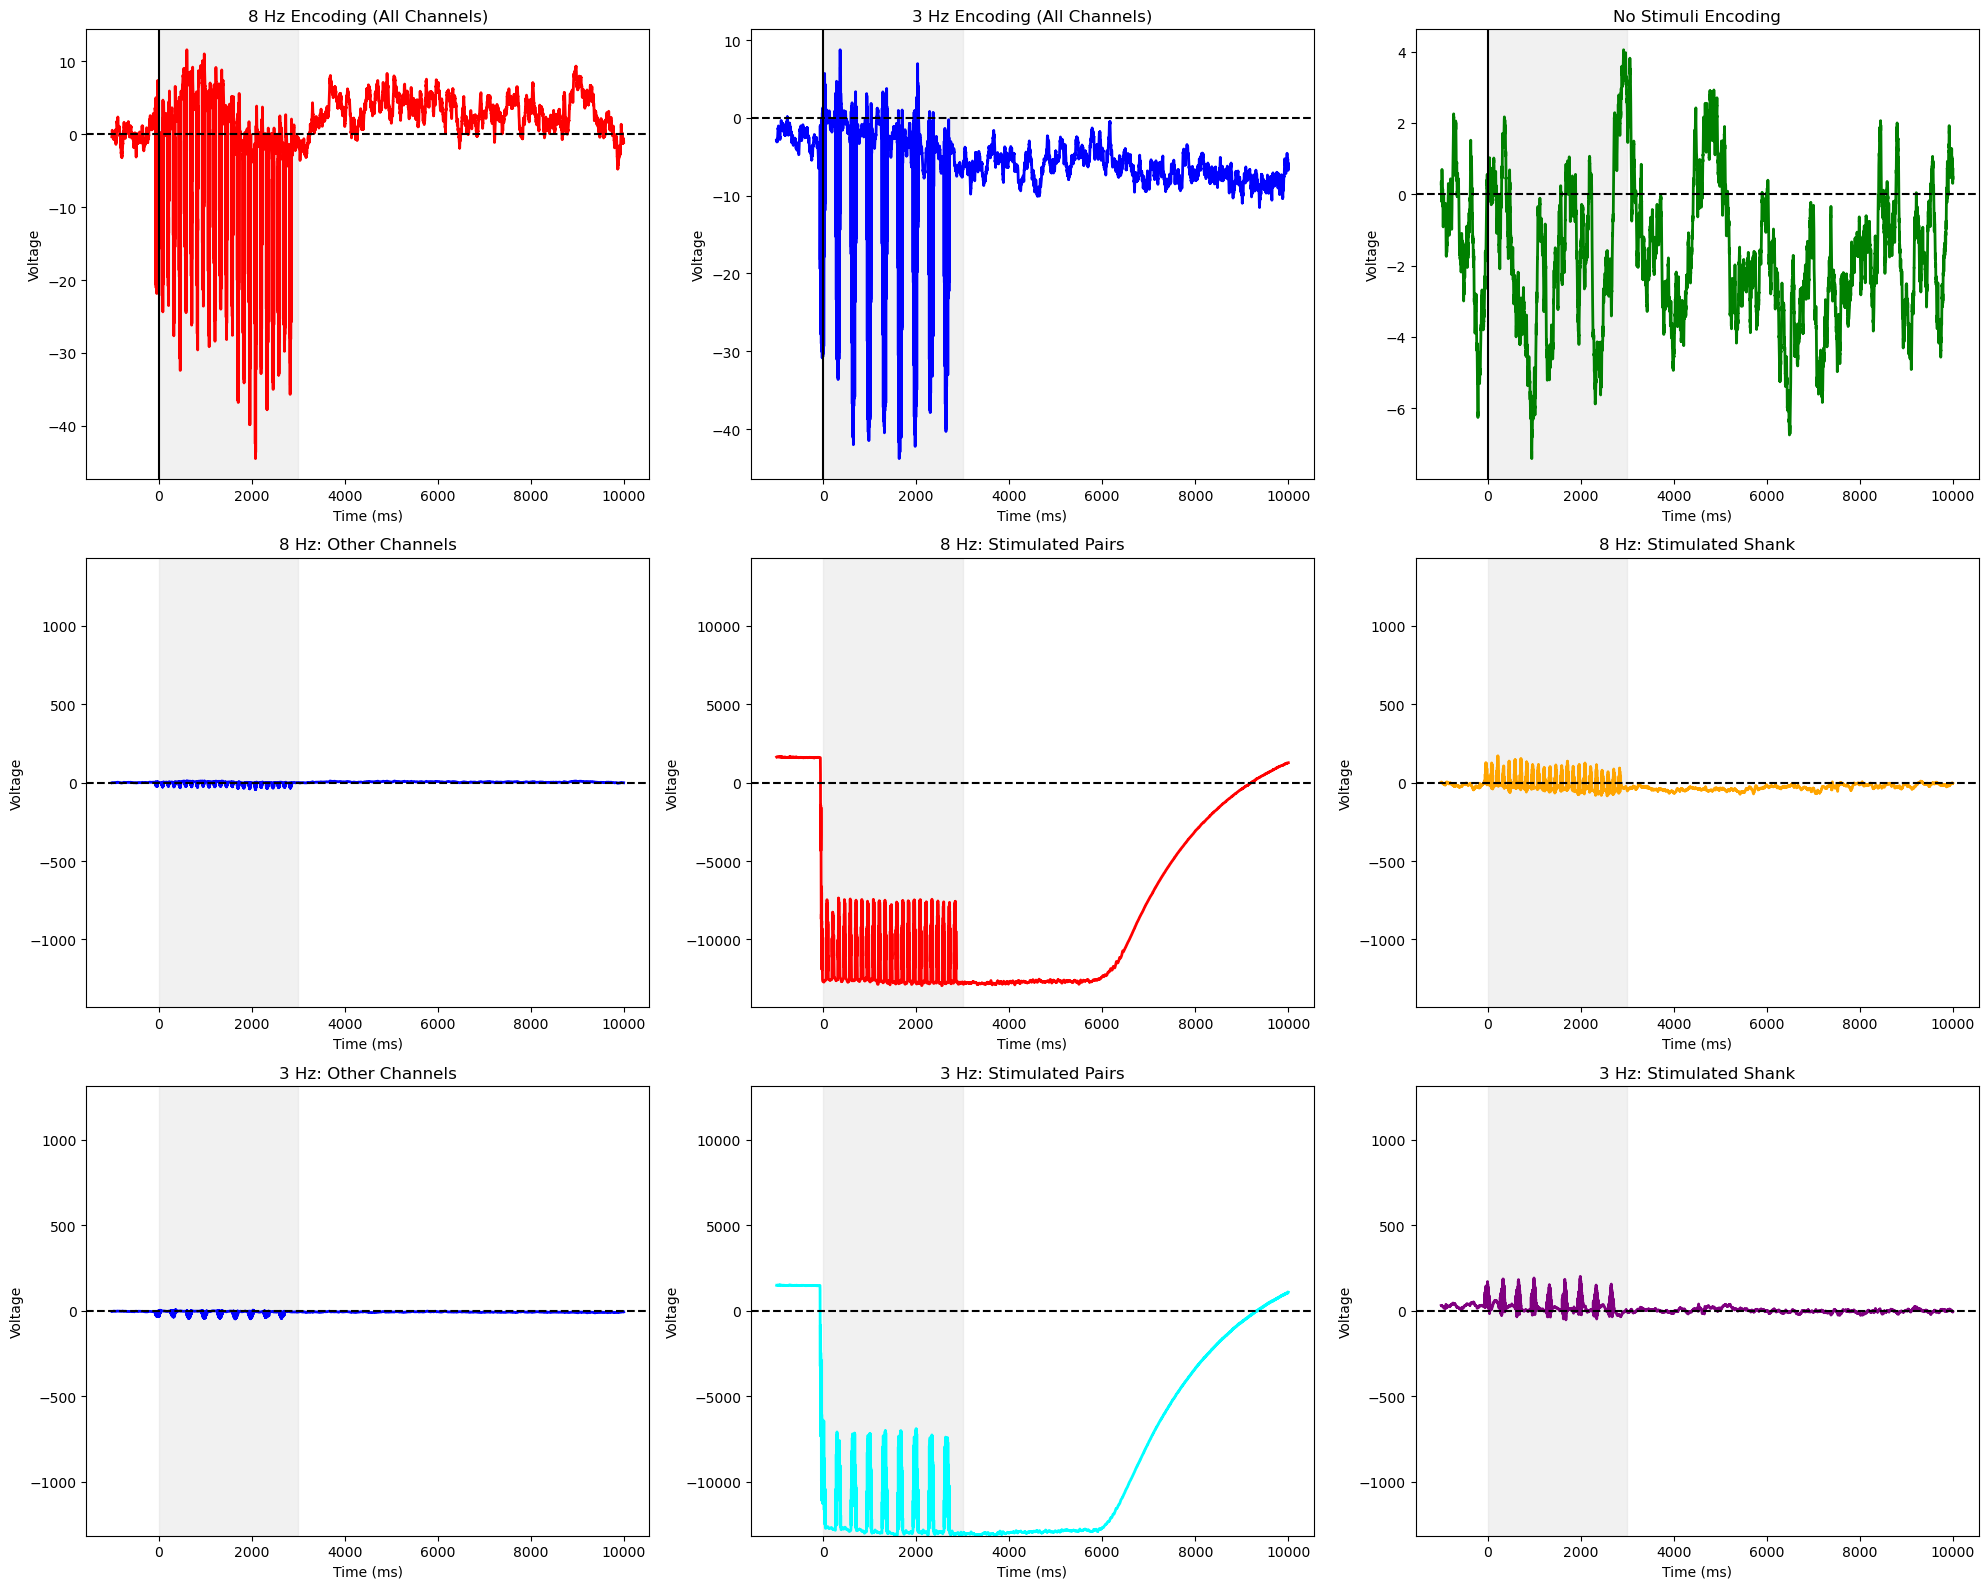

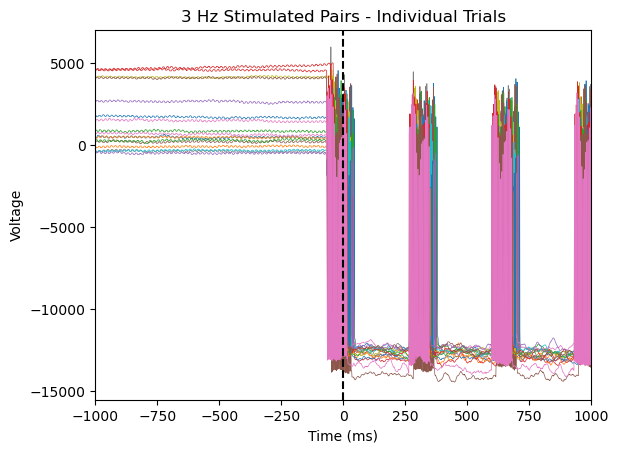

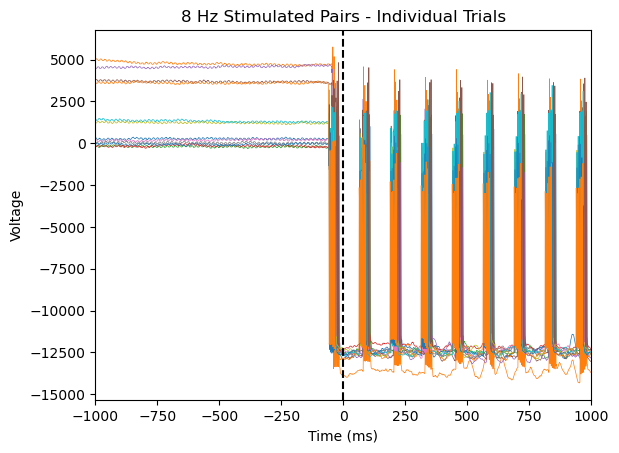


PHASE 3: CHANNEL QUALITY ASSESSMENT
--------------------------------------------------
------------------------------


No handles with labels found to put in legend.


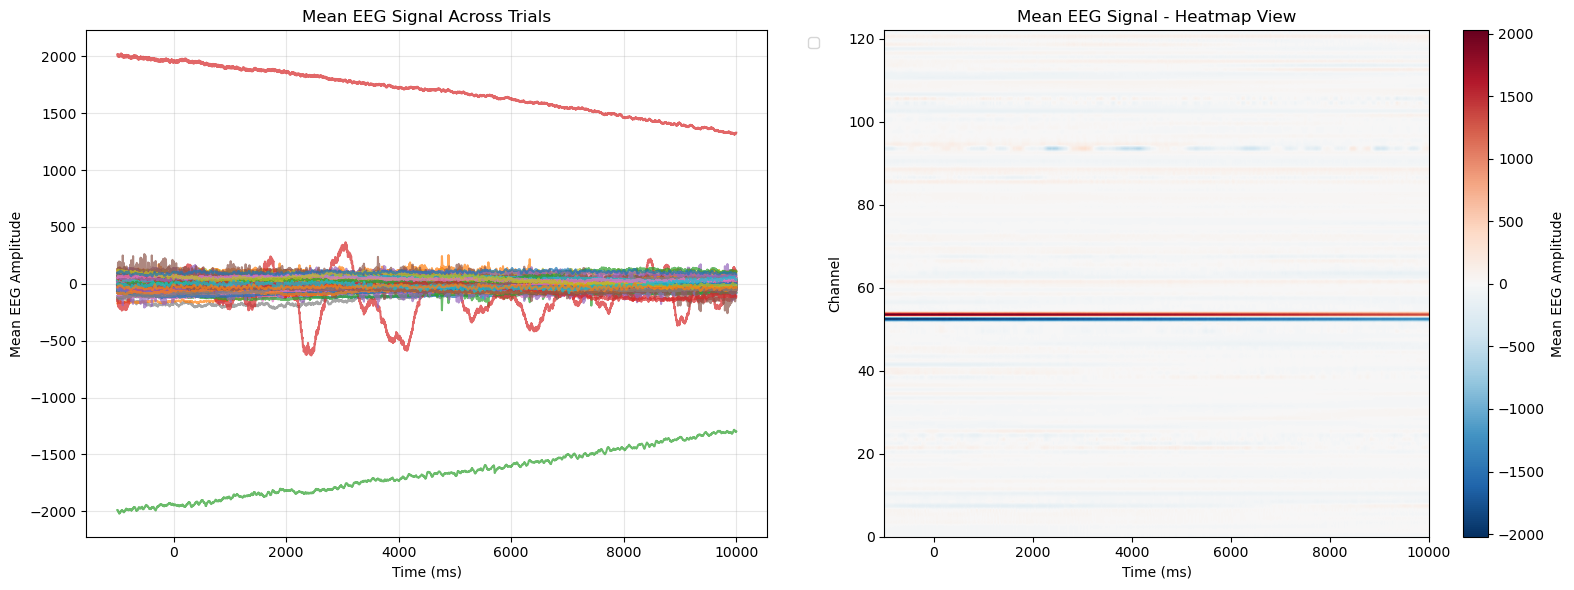

Total channels analyzed: 122
Channels with high variability (|z-score| > 2): 3

Problematic channels:
  Channel 52: RMTP4-RMTP5 (z-score: 6.75)
  Channel 53: RMTP5-RMTP6 (z-score: 6.77)
  Channel 93: RPB11-RPB12 (z-score: 2.34)


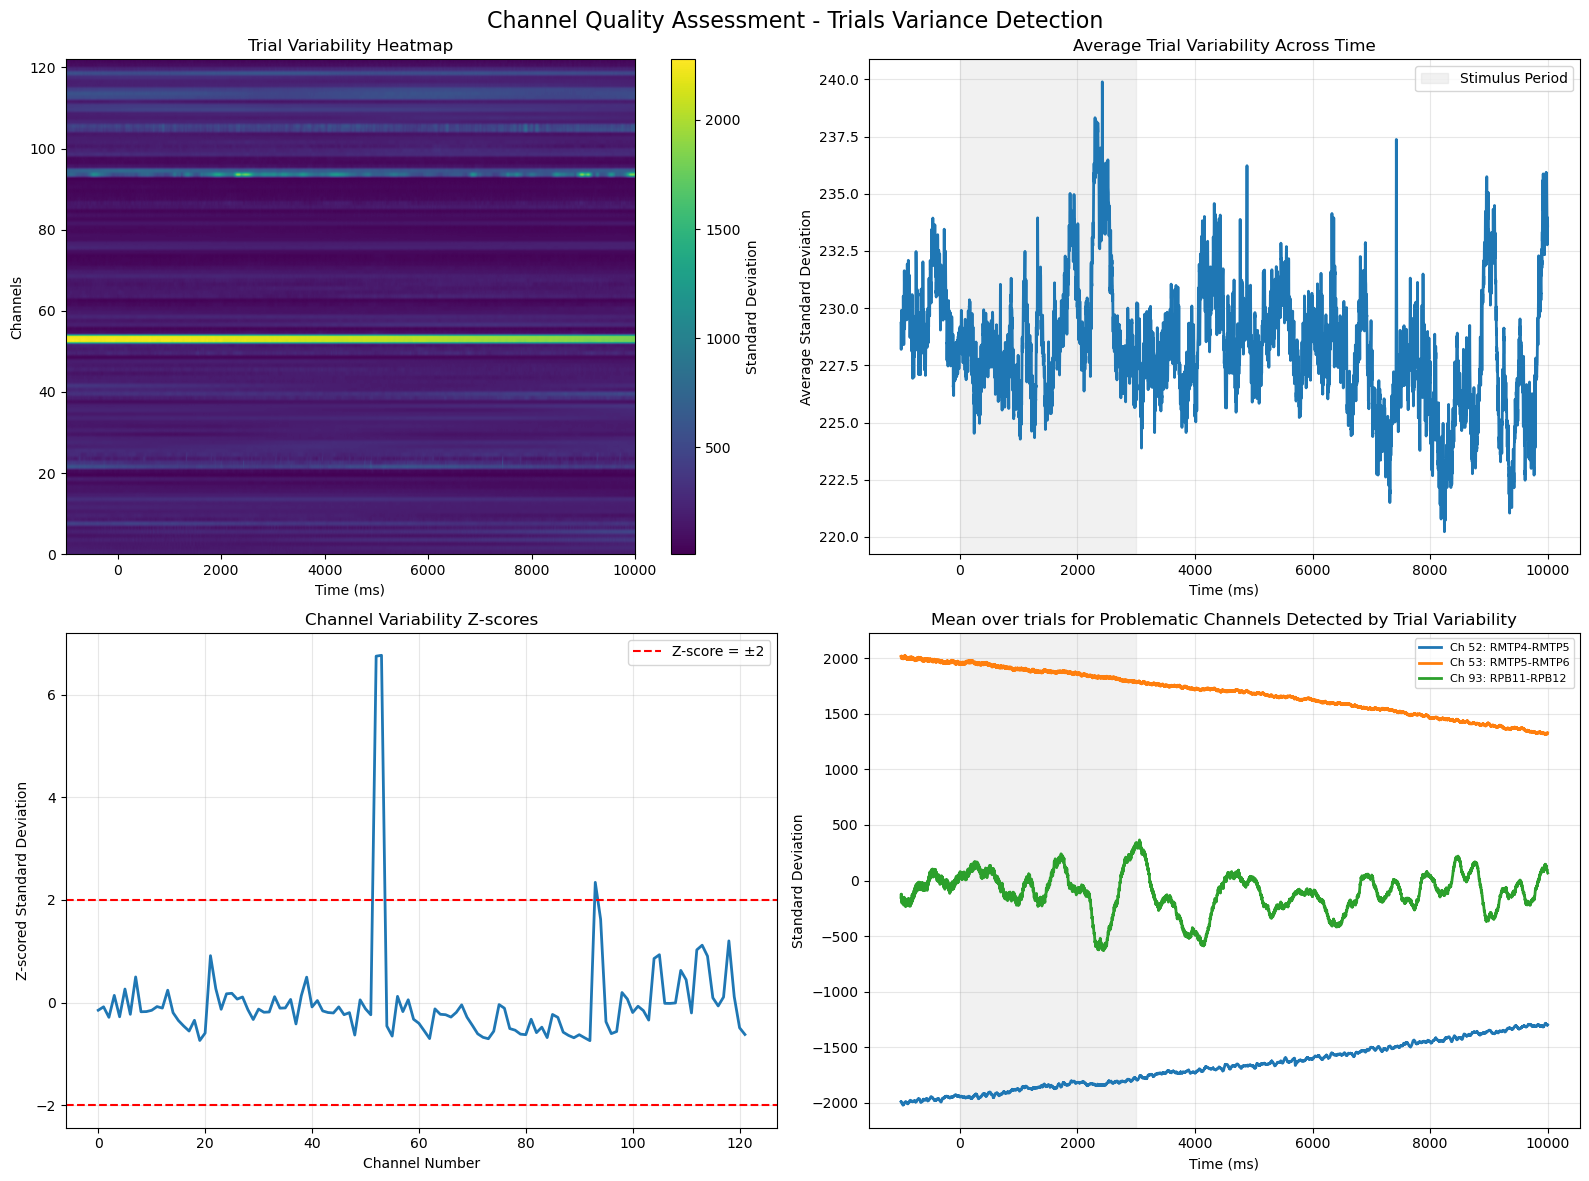

Total channels analyzed: 122
Channels with high timepoint variance (|z-score| > 2): 2

Problematic channels:
  Channel 93: RPB11-RPB12 (z-score: 9.72)
  Channel 94: RPLG1-RPLG2 (z-score: 2.62)


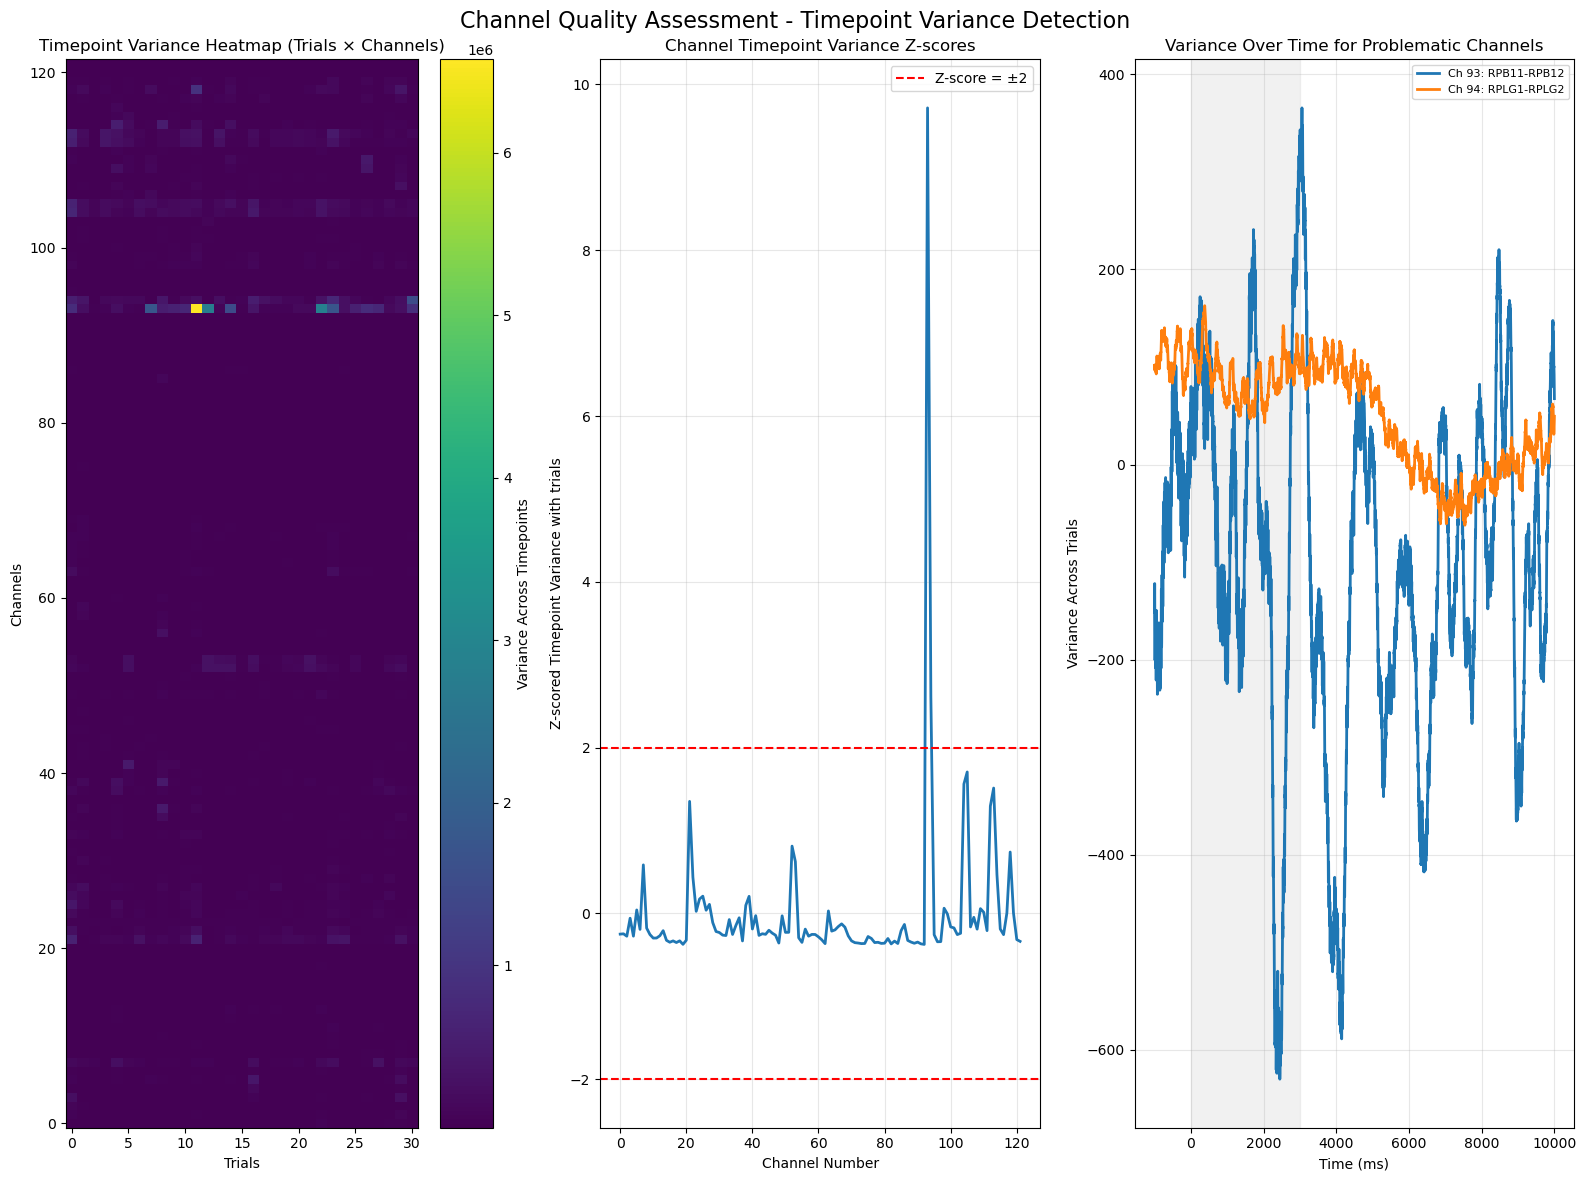


PHASE 4: Behavioral results
--------------------------------------------------
   Burst frequency (Hz)   DD  recall_rate  intrusion  Number of encoding stim  \
0                   3.0  0.0     0.583333       12.0                      5.0   
1                   8.0  1.0     0.333333        7.0                      6.0   
2                   3.0  2.0     0.250000        5.0                      6.0   
3                   8.0  3.0     0.000000        0.0                      6.0   
4                   3.0  4.0     0.166667        5.0                      6.0   

   Number of retrieval stim (EFR)  
0                            15.0  
1                            15.0  
2                            15.0  
3                            15.0  
4                            15.0  


In [11]:
# =============================================================================
# CONFIGURATION
# =============================================================================
for i in range(df_select_new['session'].nunique()):
    print("="*80)
    print(f"EEG DATA Report for subject:{subject}")
    print(f"Experiment: {exp}")
    print(f"Time window: {time_window} ms")
    print(f"Processing session {i+1} of {len(df_select_new)}")
    print("-"*80)
    
    # Get the current session data 
    df_sess = df_select_new.iloc[i]
    reader = cml.CMLReader(subject, exp, session=df_sess['session'],
                          localization=df_sess['localization'], 
                          montage=df_sess['montage'])
    
    # =============================================================================
    # PHASE 1: DATA LOGIN VERIFICATION
    # =============================================================================
    print("\nPHASE 1: DATA LOGIN VERIFICATION")
    print("-"*50)

    # Load data index and get subject data

    if df_select.empty:
        raise ValueError(f"No data found for subject {subject} in experiment {exp}")

    # Initialize reader and load events
    evs = reader.load('task_events')

    print("1.1 EVENT VERIFICATION")
    print("-"*30)

    # Define expected event counts
    expected_counts = {
        'START': 1,
        'store mappings': 1,
        'SESS_END': 1,
        'TRIAL_START': 5,
        'TRIAL_END': 5,
        'WORD': 60,
        'STIM': '89 or 91',
        'pointing begins': 65,
        'pointing finished': 65,
        'REC_START': 5,
        'REC_STOP': 5,
        'CUED_REC_CUE': 60,
        'CUED_REC_STOP': 60
    }

    # Verify event counts
    event_verification = {}
    for event_type, expected in expected_counts.items():
        actual = len(evs[evs['type'] == event_type])
        event_verification[event_type] = {
            'actual': actual,
            'expected': expected,
            'status': 'PASS' if (isinstance(expected, int) and actual == expected) or 
                               (isinstance(expected, str) and actual in [89, 91]) else 'FAIL'
        }
        print(f"{event_type}: {actual} / {expected} - {event_verification[event_type]['status']}")

    print("\n1.2 STIMULUS DELIVERY VALIDATION")
    print("-"*30)

    # Extract stimulus parameters
    pulse_freq_data = []
    word_data_type = []
    for i in range(len(evs['stim_params'])):
        freq_data = evs['stim_params'].iloc[i]['burst_freq']
        word_data = evs['type'].iloc[i]
        pulse_freq_data.append(freq_data)
        word_data_type.append(word_data)

    # Find stimulus indices
    indices_with_8 = np.where(np.array(pulse_freq_data) == 8)[0]
    indices_with_8 = indices_with_8.tolist() 
    indices_with_3 = np.where(np.array(pulse_freq_data) == 3)[0]
    indices_with_3 = indices_with_3.tolist() 
    indices_with_no = np.where(np.array(pulse_freq_data)[:-1] == -1)[0] + 1
    indices_with_no = indices_with_no.tolist()

    print(f"8 Hz stimuli events: {len(indices_with_8)}")
    print(f"3 Hz stimuli events: {len(indices_with_3)}")
    print(f"No stimuli events: {len(indices_with_no)}")

    # Add phase information to events
    def add_phase(evs):
        new_evs = pd.DataFrame([])
        for ind, list_evs in evs.groupby('trial'): # 'trial' is the aquivalent of a delivery day
            if list_evs['trial'].unique() != -999:
                list_evs['phase'] = 'nan'
            if not list_evs[list_evs['type'] == 'TRIAL_START'].index.empty:
                # find indexes of encoding start and end
                first_pointing_index = min(list_evs[list_evs['type']=='TRIAL_START'].index)
                navigation_end_index = min(list_evs[list_evs['type']=='TRIAL_END'].index) - 1
                list_evs.loc[first_pointing_index:navigation_end_index]['phase'] = 'encoding'
                # find indexes of retrieval start and end
                rec_start_index = list_evs[list_evs['type']=='REC_START'].index[0]
                rec_end_index = list_evs[list_evs['type']=='REC_STOP'].index[0]
                list_evs.loc[rec_start_index:rec_end_index]['phase'] = 'retrieval'

                if len(list_evs[list_evs.type=='FSR_START']) > 0: # relevant only for the final trial
                    # find indexes of Final FR for stores start and end
                    FSR_start_index = list_evs[list_evs['type']=='FSR_START'].index[0]
                    FSR_end_index = list_evs[list_evs['type']=='FSR_STOP'].index[0]
                    list_evs.loc[FSR_start_index:FSR_end_index]['phase'] = 'FSR'

                     # find indexes of Final FR for items start and end
                    FFR_start_index = list_evs[list_evs['type']=='FFR_START'].index[0]
                    FFR_end_index = list_evs[list_evs['type']=='FFR_STOP'].index[0]
                    list_evs.loc[FFR_start_index:FFR_end_index]['phase'] = 'FFR'

            elif list_evs['trial'].unique() == -999:
                list_evs['phase'] = 'nan'

            new_evs = pd.concat([new_evs, list_evs])
        return new_evs
    
    evs = add_phase(evs)
    
    # Analyze stimuli by phase
    result_8HZ_encoding = evs[(evs.index.isin(indices_with_8)) & (evs['phase'] == 'encoding')]
    result_3HZ_encoding = evs[(evs.index.isin(indices_with_3)) & (evs['phase'] == 'encoding')] 
    result_none_encoding = evs[(evs.index.isin(indices_with_no)) & (evs['phase'] == 'encoding') & (evs['type'] == 'WORD')]
    result_8HZ_retrieval = evs[(evs.index.isin(indices_with_8)) & (evs['phase'] == 'retrieval')]
    result_3HZ_retrieval = evs[(evs.index.isin(indices_with_3)) & (evs['phase'] == 'retrieval')]
    print(f"\nStimuli distribution by phase:")
    print(f"Encoding - 3 Hz: {len(result_3HZ_encoding)}, 8 Hz: {len(result_8HZ_encoding)}, None: {len(result_none_encoding)}")
    print(f"Retrieval - 3 Hz: {len(result_3HZ_retrieval)}, 8 Hz: {len(result_8HZ_retrieval)}")

    # =============================================================================
    # PHASE 2: FREQUENCY ANALYSIS (3-8 Hz Peak Detection)
    # =============================================================================
    print("\n" + "="*80)
    print("PHASE 2: FREQUENCY ANALYSIS (3-8 Hz Peak Detection)")
    print("-"*50)

    # Load EEG data - reader is already initialized
    evs = reader.load("events")
    channels = reader.load("pairs")

    # Load EEG for different conditions
    print("Loading EEG data...")
    eeg_container_8HZ_encoding = reader.load_eeg(result_8HZ_encoding, -1000, time_window, scheme=channels)
    eeg_container_3HZ_encoding = reader.load_eeg(result_3HZ_encoding, -1000, time_window, scheme=channels)
    eeg_container_8HZ_retrieval = reader.load_eeg(result_8HZ_retrieval, -1000, time_window, scheme=channels)
    eeg_container_3HZ_retrieval = reader.load_eeg(result_3HZ_retrieval, -1000, time_window, scheme=channels)
    eeg_container_no_encoding = reader.load_eeg(result_none_encoding, -1000, time_window, scheme=channels)
                                
    # Extract data arrays
    eeg_8HZ = eeg_container_8HZ_encoding.data
    eeg_3HZ = eeg_container_3HZ_encoding.data
    eeg_8HZ_retrieval = eeg_container_8HZ_retrieval.data
    eeg_3HZ_retrieval = eeg_container_3HZ_retrieval.data
    eeg_no_encoding = eeg_container_no_encoding.data
    sr = eeg_container_8HZ_encoding.samplerate

    # Create time axis starting from -1000ms
    total_samples = eeg_8HZ.shape[2]
    time_axis = np.linspace(-1000, time_window, total_samples)

    print(f"Sample rate: {sr} Hz")
    print(f"EEG data shapes:")
    print(f"  8 Hz encoding: {eeg_8HZ.shape}")
    print(f"  3 Hz encoding: {eeg_3HZ.shape}")
    print(f"  No stimuli encoding: {eeg_no_encoding.shape}")
    print(f"Time axis range: {time_axis[0]:.1f} to {time_axis[-1]:.1f} ms")

    # Identify stimulated channels
    def identify_stimulated_channels(evs, indices, channels):
        """Identify stimulated channel pairs and related channels"""
        stimulated_pairs = []
        stimulated_contacts = []
        
        # Extract stimulated electrode labels
        for ind in indices:
            stim_params = evs['stim_params'].loc[ind]
            anode_label = stim_params['anode_label']
            cathode_label = stim_params['cathode_label']

            # Store the exact stimulated pair
            pair_label1 = anode_label + '-' + cathode_label
            pair_label2 = cathode_label + '-' + anode_label
            stimulated_pairs.extend([pair_label1, pair_label2])

            # Store individual stimulated contacts
            stimulated_contacts.extend([anode_label, cathode_label])

        # Remove duplicates
        stimulated_pairs = list(set(stimulated_pairs))
        stimulated_contacts = list(set(stimulated_contacts))
        
        # Find indices for each category
        contact_stimuli_indices = []  # Exact stimulated pairs
        channel_stimuli_indices = []  # Channels on same shank/related to stimulated contacts
        relative_indices = []         # Individual stimulated contacts

        # 1. Find exact stimulated pairs (Contact_stimuli)
        for pair_label in stimulated_pairs:
            mask = channels['label'].str.contains(pair_label, na=False, regex=False)
            contact_indices = channels.loc[mask].index.tolist()
            contact_stimuli_indices.extend(contact_indices)

        # 2. Find individual stimulated contacts (relative_index)
        for contact_label in stimulated_contacts:
            mask = channels['label'].str.contains(contact_label, na=False, regex=False)
            contact_indices = channels.loc[mask].index.tolist()
            relative_indices.extend(contact_indices)

        # 3. Find channels on same shank (Channel_stimuli)
        # Remove numbers from contact labels to find related channels on same shank
        for contact_label in stimulated_contacts:
            cleaned_label = re.sub(r'\d+', '', contact_label)  # Remove numbers
            if cleaned_label:  # Make sure we have a valid label after cleaning
                mask = channels['label'].str.replace(r'\d+', '', regex=True).str.contains(
                    cleaned_label, na=False, regex=False)
                shank_indices = channels.loc[mask].index.tolist()
                channel_stimuli_indices.extend(shank_indices)
        
        # Remove duplicates and ensure proper categorization
        contact_stimuli_indices = list(set(contact_stimuli_indices))
        relative_indices = list(set(relative_indices))
        channel_stimuli_indices = list(set(channel_stimuli_indices))

        # Channel_stimuli should exclude exact pairs and individual contacts
        channel_stimuli_indices = [x for x in channel_stimuli_indices 
                                  if x not in contact_stimuli_indices 
                                  and x not in relative_indices]
        
        # Index_other includes all other channels
        all_channels = list(range(len(channels)))
        all_stimulated = list(set(contact_stimuli_indices + channel_stimuli_indices + relative_indices))
        index_other = [x for x in all_channels if x not in all_stimulated]

        return index_other, channel_stimuli_indices, contact_stimuli_indices

    # Identify channels for both frequencies
    Index_other_8, Channel_stimuli_8, Contact_stimuli_8 = identify_stimulated_channels(evs, indices_with_8, channels)
    Index_other_3, Channel_stimuli_3, Contact_stimuli_3 = identify_stimulated_channels(evs, indices_with_3, channels)
    #  Remove bad_channel if any 
    Index_other_8 = [x for x in Index_other_8 
                                  if x not in bed_channel 
                                  ]
    Contact_stimuli_3 = [x for x in Contact_stimuli_3 
                                  if x not in bed_channel 
                                  ]
    
    Channel_stimuli_8 = [x for x in Channel_stimuli_8 
                                  if x not in bed_channel 
                                  ]
    
    print(f"\n8 Hz stimulated contacts: {Contact_stimuli_8}")
    print(f"3 Hz stimulated contacts: {Contact_stimuli_3}")

    # =============================================================================
    # VISUALIZATION: EEG RESPONSES BY CONDITION
    # =============================================================================
    print("\n2.1 EEG Response for simulation Visualization")
    print("-"*30)

    # Create comprehensive visualization
    fig = plt.figure(figsize=(20, 16))
    channel = [i for i in range(np.shape(eeg_8HZ)[1]) if i not in bed_channel]
    
    # Define stimulus period in time coordinates
    stim_start_time, stim_end_time = 0, 3000  # ms
    
    # Plot 1: Overall EEG responses (2x2 grid)
    ax1 = plt.subplot(3, 3, 1)
    avg_eeg = np.mean(eeg_8HZ[:, channel, :], 0)
    plt.plot(time_axis, np.mean(avg_eeg[:, :], 0), linewidth=2, color='red')
    plt.axvline(x=0, color='k', linestyle='-')
    plt.axhline(y=0, color='k', linestyle='--')
    plt.xlabel('Time (ms)')
    plt.ylabel('Voltage')
    plt.title('8 Hz Encoding (All Channels)')
    plt.axvspan(stim_start_time, stim_end_time, alpha=0.3, color='lightgrey')

    ax2 = plt.subplot(3, 3, 2)
    avg_eeg = np.mean(eeg_3HZ[:, channel, :], 0)
    plt.plot(time_axis, np.mean(avg_eeg[:, :], 0), linewidth=2, color='blue')
    plt.axvline(x=0, color='k', linestyle='-')
    plt.axhline(y=0, color='k', linestyle='--')
    plt.xlabel('Time (ms)')
    plt.ylabel('Voltage')
    plt.title('3 Hz Encoding (All Channels)')
    plt.axvspan(stim_start_time, stim_end_time, alpha=0.3, color='lightgrey')

    ax3 = plt.subplot(3, 3, 3)
    avg_eeg = np.mean(eeg_no_encoding[:, channel, :], 0)
    plt.plot(time_axis, np.mean(avg_eeg[:, :], 0), linewidth=2, color='green')
    plt.axvline(x=0, color='k', linestyle='-')
    plt.axhline(y=0, color='k', linestyle='--')
    plt.xlabel('Time (ms)')
    plt.ylabel('Voltage')
    plt.title('No Stimuli Encoding')
    plt.axvspan(stim_start_time, stim_end_time, alpha=0.3, color='lightgrey')
  
    # Plot 2: Channel-specific analysis for 8 Hz
    if Contact_stimuli_8:
        avg_eeg_other_8 = np.mean(eeg_8HZ[:, Index_other_8, :], axis=1)
        avg_eeg_stimuli_8 = np.mean(eeg_8HZ[:, Contact_stimuli_8, :], axis=1)
        avg_eeg_channel_8 = np.mean(eeg_8HZ[:, Channel_stimuli_8, :], axis=1)

        ax4 = plt.subplot(3, 3, 4)
        plt.plot(time_axis, np.mean(avg_eeg_other_8, axis=0), linewidth=2, color='blue', label='Other Channels')
        plt.axhline(y=0, color='k', linestyle='--')
        plt.xlabel('Time (ms)')
        plt.ylabel('Voltage')
        plt.title('8 Hz: Other Channels')
        plt.axvspan(stim_start_time, stim_end_time, alpha=0.3, color='lightgrey')
        ax4_max = np.max(np.abs(avg_eeg_stimuli_8))/10
        ax4.set_ylim(-ax4_max, ax4_max)
        
        ax5 = plt.subplot(3, 3, 5)
        plt.plot(time_axis, np.mean(avg_eeg_stimuli_8, axis=0), linewidth=2, color='red', label='Stimulated Pairs')
        plt.axhline(y=0, color='k', linestyle='--')
        plt.xlabel('Time (ms)')
        plt.ylabel('Voltage')
        plt.title('8 Hz: Stimulated Pairs')
        plt.axvspan(stim_start_time, stim_end_time, alpha=0.3, color='lightgrey')
        ax5_max = np.max(np.abs(avg_eeg_stimuli_8))
        ax5.set_ylim(-ax5_max, ax5_max)

        ax6 = plt.subplot(3, 3, 6)
        plt.plot(time_axis, np.mean(avg_eeg_channel_8, axis=0), linewidth=2, color='orange', label='Stimulated Shank')
        plt.axhline(y=0, color='k', linestyle='--')
        plt.xlabel('Time (ms)')
        plt.ylabel('Voltage')
        plt.title('8 Hz: Stimulated Shank')
        plt.axvspan(stim_start_time, stim_end_time, alpha=0.3, color='lightgrey')
        ax6_max = np.max(np.abs(avg_eeg_stimuli_8))/10
        ax6.set_ylim(-ax6_max, ax6_max)

    # Plot 3: Channel-specific analysis for 3 Hz
    if Contact_stimuli_3:
        avg_eeg_other_3 = np.mean(eeg_3HZ[:, Index_other_3, :], axis=1)
        avg_eeg_stimuli_3 = np.mean(eeg_3HZ[:, Contact_stimuli_3, :], axis=1)
        avg_eeg_channel_3 = np.mean(eeg_3HZ[:, Channel_stimuli_3, :], axis=1)

        ax7 = plt.subplot(3, 3, 7)
        plt.plot(time_axis, np.mean(avg_eeg_other_3, axis=0), linewidth=2, color='blue', label='Other Channels')
        plt.axhline(y=0, color='k', linestyle='--')
        plt.xlabel('Time (ms)')
        plt.ylabel('Voltage')
        plt.title('3 Hz: Other Channels')
        plt.axvspan(stim_start_time, stim_end_time, alpha=0.3, color='lightgrey')

        ax8 = plt.subplot(3, 3, 8)
        mean_stimuli_3 = np.mean(avg_eeg_stimuli_3, axis=0)
        plt.plot(time_axis, mean_stimuli_3, linewidth=2, color='cyan', label='Stimulated Pairs')
        plt.axhline(y=0, color='k', linestyle='--')
        plt.xlabel('Time (ms)')
        plt.ylabel('Voltage')
        plt.title('3 Hz: Stimulated Pairs')
        plt.axvspan(stim_start_time, stim_end_time, alpha=0.3, color='lightgrey')
        
        # Set ax8 y-limits to its maximum value
        ax8_max = np.max(np.abs(mean_stimuli_3))
        ax8.set_ylim(-ax8_max, ax8_max)
        
        # Calculate reduced range for ax7 and ax9
        reduced_range = ax8_max / 10

        ax9 = plt.subplot(3, 3, 9)
        plt.plot(time_axis, np.mean(avg_eeg_channel_3, axis=0), linewidth=2, color='purple', label='Stimulated Shank')
        plt.axhline(y=0, color='k', linestyle='--')
        plt.xlabel('Time (ms)')
        plt.ylabel('Voltage')
        plt.title('3 Hz: Stimulated Shank')
        plt.axvspan(stim_start_time, stim_end_time, alpha=0.3, color='lightgrey')
        
        # Set ax7 and ax9 y-limits to ax8_max / 10
        ax7.set_ylim(-reduced_range, reduced_range)
        ax9.set_ylim(-reduced_range, reduced_range)

    plt.tight_layout()
    plt.show()
    
    fig, ax10 = plt.subplots()
    ax10.plot(time_axis, avg_eeg_stimuli_3.T, linewidth=0.5)
    ax10.axvline(x=0, color='k', linestyle='--')
    ax10.set_xlim(-1000, 1000)
    ax10.set_xlabel('Time (ms)')
    ax10.set_ylabel('Voltage')
    ax10.set_title('3 Hz Stimulated Pairs - Individual Trials')
    plt.show()
    
    fig, ax10 = plt.subplots()
    ax10.plot(time_axis, avg_eeg_stimuli_8.T, linewidth=0.5)
    ax10.axvline(x=0, color='k', linestyle='--')
    ax10.set_xlim(-1000, 1000)
    ax10.set_xlabel('Time (ms)')
    ax10.set_ylabel('Voltage')
    ax10.set_title('8 Hz Stimulated Pairs - Individual Trials')
    plt.show()
    
    # =============================================================================
    # PHASE 3: CHANNEL QUALITY ASSESSMENT
    # =============================================================================
    print("\n" + "="*80)
    print("PHASE 3: CHANNEL QUALITY ASSESSMENT")
    print("-"*50)

    
    print("-"*30)
      # Raw DATA :
      # Create subplots with 1 row and 2 columns
    
    eeg_mean = np.mean(eeg_no_encoding[:, channel, :], 0)
    # First subplot - Line plot
    # Plot each channel (rows 1-9 from the mean result)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    for i in range(eeg_mean.shape[0]):
        ax1.plot(time_axis, eeg_mean[i, :], alpha=0.7)
    ax1.set_xlabel('Time (ms)')
    ax1.set_ylabel('Mean EEG Amplitude')
    ax1.set_title('Mean EEG Signal Across Trials')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.grid(True, alpha=0.3)

    # Second subplot - Heatmap
    im = ax2.imshow(eeg_mean, aspect='auto', cmap='RdBu_r', origin='lower', 
                    extent=[time_axis[0], time_axis[-1], 0, eeg_mean.shape[0]])
    plt.colorbar(im, ax=ax2, label='Mean EEG Amplitude')
    ax2.set_xlabel('Time (ms)')
    ax2.set_ylabel('Channel')
    ax2.set_title('Mean EEG Signal - Heatmap View')
    # ax2.set_yticks(range(eeg_mean.shape[0]), [f'Ch {i+2}' for i in range(eeg_mean.shape[0])])

    plt.tight_layout()
    plt.show()
 
    # Compute trial variability 
    trial_variability = np.std(eeg_no_encoding[:,channel, :],axis=0)  # Shape: (channels, timepoints)
    timepoint_variability = np.mean(trial_variability, axis=0)  # Average across channels
    channel_variability = np.mean(trial_variability, axis=1)  # Average across timepoints

    # Z-score channel variability to identify outliers
    channel_variability_z = zscore(channel_variability)
    problematic_channels = np.where(np.abs(channel_variability_z) > 2)[0]

    print(f"Total channels analyzed: {len(channels)}")
    print(f"Channels with high variability (|z-score| > 2): {len(problematic_channels)}")

    if len(problematic_channels) > 0:
        print("\nProblematic channels:")
        for ch_idx in problematic_channels:
            if ch_idx < len(channels):
                print(f"  Channel {ch_idx}: {channels.iloc[ch_idx]['label']} (z-score: {channel_variability_z[ch_idx]:.2f})")

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Channel Quality Assessment - Trials Variance Detection', fontsize=16)
    # Heatmap of trial variability
    ax1 = axes[0, 0]
    im = ax1.imshow(trial_variability, aspect='auto', cmap='viridis', origin='lower',
                    extent=[time_axis[0], time_axis[-1], 0, trial_variability.shape[0]])
    ax1.set_xlabel('Time (ms)')
    ax1.set_ylabel('Channels')
    ax1.set_title('Trial Variability Heatmap')
    plt.colorbar(im, ax=ax1, label='Standard Deviation')

    # Average variability across time
    ax2 = axes[0, 1]
    ax2.plot(time_axis, timepoint_variability, linewidth=2)
    ax2.set_xlabel('Time (ms)')
    ax2.set_ylabel('Average Standard Deviation')
    ax2.set_title('Average Trial Variability Across Time')
    ax2.grid(True, alpha=0.3)
    ax2.axvspan(stim_start_time, stim_end_time, alpha=0.3, color='lightgrey', label='Stimulus Period')
    ax2.legend()

    # Channel variability z-scores
    ax3 = axes[1, 0]
    ax3.plot(channel_variability_z, linewidth=2)
    ax3.axhline(y=2, color='r', linestyle='--', label='Z-score = ±2')
    ax3.axhline(y=-2, color='r', linestyle='--')
    ax3.set_xlabel('Channel Number')
    ax3.set_ylabel('Z-scored Standard Deviation')
    ax3.set_title('Channel Variability Z-scores')
    ax3.grid(True, alpha=0.3)
    ax3.legend()

    # Problematic channels over time
    ax4 = axes[1, 1]
    if len(problematic_channels) > 0:
        for ch in problematic_channels[:5]:  # Plot up to 5 problematic channels
            if ch < trial_variability.shape[0]:
                ax4.plot(time_axis, np.mean(eeg_no_encoding[:, ch, :], axis=0), 
                        label=f'Ch {ch}: {channels.iloc[ch]["label"] if ch < len(channels) else "Unknown"}', 
                        linewidth=2)
        ax4.set_xlabel('Time (ms)')
        ax4.set_ylabel('Standard Deviation')
        ax4.set_title('Mean over trials for Problematic Channels Detected by Trial Variability')
        ax4.grid(True, alpha=0.3)
        ax4.legend(fontsize=8)
        ax4.axvspan(stim_start_time, stim_end_time, alpha=0.3, color='lightgrey')

    plt.tight_layout()
    plt.show()
    
    timepoint_variance = np.var(eeg_no_encoding, axis=2)  # Shape: (trials, channels) - variance across timepoints
    trial_averaged_variance = np.mean(timepoint_variance, axis=0)  # Shape: (channels,) - average across trials

    # For visualization: compute variance for each channel at each timepoint (averaged across trials)
    channel_timepoint_variance = np.var(np.mean(eeg_no_encoding, axis=0), axis=1)  # Shape: (channels,) - variance across timepoints for trial-averaged data
    timepoint_channel_variance = np.var(np.mean(eeg_no_encoding, axis=0), axis=0)  # Shape: (timepoints,) - variance across channels for trial-averaged data

    # Z-score channel variance to identify outliers
    channel_variance_z = zscore(trial_averaged_variance)
    problematic_channels = np.where(np.abs(channel_variance_z) > 2)[0]

    print(f"Total channels analyzed: {len(channels)}")
    print(f"Channels with high timepoint variance (|z-score| > 2): {len(problematic_channels)}")
    if len(problematic_channels) > 0:
        print("\nProblematic channels:")
        for ch_idx in problematic_channels:
            if ch_idx < len(channels):
                print(f"  Channel {ch_idx}: {channels.iloc[ch_idx]['label']} (z-score: {channel_variance_z[ch_idx]:.2f})")

    # Visualization of artifact detection
    fig, axes = plt.subplots(1, 3, figsize=(16, 12))
    fig.suptitle('Channel Quality Assessment - Timepoint Variance Detection', fontsize=16)

    # Heatmap of timepoint variance across trials and channels
    ax1 = axes[0]
    im = ax1.imshow(timepoint_variance.T, aspect='auto', cmap='viridis', origin='lower')
    ax1.set_xlabel('Trials')
    ax1.set_ylabel('Channels')
    ax1.set_title('Timepoint Variance Heatmap (Trials × Channels)')
    plt.colorbar(im, ax=ax1, label='Variance Across Timepoints')

    # Channel variance z-scores
    ax2 = axes[1]
    ax2.plot(channel_variance_z, linewidth=2)
    ax2.axhline(y=2, color='r', linestyle='--', label='Z-score = ±2')
    ax2.axhline(y=-2, color='r', linestyle='--')
    ax2.set_xlabel('Channel Number')
    ax2.set_ylabel('Z-scored Timepoint Variance with trials')
    ax2.set_title('Channel Timepoint Variance Z-scores')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    trial_averaged_data=np.mean(eeg_no_encoding[:, :, :], axis=0)
    # Problematic channels - timepoint variance profiles
    ax4 = axes[2]
    if len(problematic_channels) > 0:
        for ch in problematic_channels[:5]:  # Plot up to 5 problematic channels
            if ch < trial_averaged_data.shape[0]:
                channel_variance_over_time = np.mean(eeg_no_encoding[:, ch, :], axis=0)  # Variance across trials at each timepoint
                ax4.plot(time_axis, channel_variance_over_time, 
                        label=f'Ch {ch}: {channels.iloc[ch]["label"] if ch < len(channels) else "Unknown"}', 
                        linewidth=2)
        ax4.set_xlabel('Time (ms)')
        ax4.set_ylabel('Variance Across Trials')
        ax4.set_title('Variance Over Time for Problematic Channels')
        ax4.grid(True, alpha=0.3)
        ax4.legend(fontsize=8)
        ax4.axvspan(stim_start_time, stim_end_time, alpha=0.3, color='lightgrey')
    else:
        ax4.text(0.5, 0.5, 'No problematic channels detected', 
                 ha='center', va='center', transform=ax4.transAxes, fontsize=12)
        ax4.set_title('Mean over trial for Problematic Channels Detected by Temporal Variability within Trial')

    plt.tight_layout()
    plt.show()
    # =============================================================================
    # PHASE 4: BEHAVIORAL RESULTS
    # =============================================================================
    print("\n" + "="*80)
    print("PHASE 4: Behavioral results")
    print("-"*50)
    evs = add_phase(evs)
    parameters_df2=pd.DataFrame([])
    for i,delivery_day_df in evs.groupby('trial'):
        if delivery_day_df['trial'].unique()>=0:
            encoding_df=delivery_day_df[delivery_day_df['phase']=='encoding']
            encoding_stim_num = len(encoding_df[encoding_df['type']=='STIM'])
            retrieval_df=delivery_day_df[delivery_day_df['phase']=='retrieval']
            retrieval_stim_num = len(retrieval_df[retrieval_df['type']=='STIM'])
            recall_rate = len(delivery_day_df[delivery_day_df['recalled']==1]) / (len(delivery_day_df[delivery_day_df['recalled']==0]) + len(delivery_day_df[delivery_day_df['recalled']==1]))
            intrusion = len(delivery_day_df[(delivery_day_df['intrusion']==1) | (delivery_day_df['intrusion']==0)]) 
            stim_df=delivery_day_df[delivery_day_df['type']=='STIM']
            burst_freq=stim_df['stim_params'].iloc[0]['burst_freq']

            parameters_df2 = parameters_df2.append({'Burst frequency (Hz)':burst_freq,'DD':delivery_day_df['trial'].unique()[0],'recall_rate':recall_rate,'intrusion':intrusion,
                                                   'Number of encoding stim':encoding_stim_num,'Number of retrieval stim (EFR)':retrieval_stim_num
                                                   },ignore_index=True)
    #         parameters_df2 = parameters_df2.append({'Burst frequency (Hz)':burst_freq,'DD':delivery_day_df['trial'].unique()[0],
    #                                                'Number of encoding stim':encoding_stim_num,'Number of retrieval stim (EFR)':retrieval_stim_num,
    #                                                'Number of FSR stim':FSR_stim_num,'Number of FFR stim':FFR_stim_num},ignore_index=True)
    print(parameters_df2)